# Sentiment Analysis using BERT

## **What is Sentiment Analysis ?**
* Sentiment Analysis is a major task in Natural Language Processing (NLP) field.
* It is used to understand the sentiments of the customer/people for products, movies, and other such things, whether they feel positive, negative, or neutral about it.
* It helps companies and other related entities to know about their products/services and helps them to work on the feedback to further improve it.
## What is BERT and DistilBert?
* BERT (Bidirectional Encoder Representations from Transformers): A powerful pre-trained language model developed by Google AI. BERT excels at various NLP tasks, including sentiment analysis.
* DistilBERT: A smaller and faster version of BERT, designed for deployment on devices with limited resources. DistilBERT retains good performance while offering improved efficiency.

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Loading necessary library

import time

import tensorflow as tf
import tensorflow_datasets as tfds

from IPython.display import clear_output

import sklearn
from tqdm import tqdm
# visualization
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

#NLP libraries
import nltk
from nltk.corpus import stopwords
# BERT Classifier and Tokenizer along with Input module
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

#metrics
from sklearn.model_selection import train_test_split
# splitting
from sklearn.metrics import classification_report

In [4]:
# !pip uninstall tf_keras -y

In [5]:
# Check for available GPU devices
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("GPU is not available. Code execution will proceed on CPU.")

GPU is available!


In [6]:
df=pd.read_csv("data_transformed_imdb.csv")
df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1


# Sentiment Analysis with BERT

In [7]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)
X_train.head()

39087    thats kept asking many fights screaming matche...
30893    watch entire movie could watch entire movie st...
45278    touching love story reminiscent mood love draw...
16398    latterday fulci schlocker totally abysmal conc...
13653    first firmly believe norwegian movies continua...
Name: review, dtype: object

In [8]:
# Create TensorFlow datasets
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [9]:
ds_train

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
# initializing the tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
clear_output()

The encode_plus function of the tokenizer class will tokenize the raw input, add the special tokens, and pad the vector to a size equal to max length (that we can set).

In [11]:
def convert_example_to_feature(review):
    return tokenizer.encode_plus(review,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

In [12]:
# can be up to 512 for BERT
max_length = 512
batch_size = 6

In [13]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [14]:
# prepare list, so that we can build up final TensorFlow dataset from slices.
def encode_examples(ds, limit=-1):
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    if (limit > 0):
        ds = ds.take(limit)
    for review, label in tfds.as_numpy(ds):
        bert_input = convert_example_to_feature(review.decode())
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)


In [15]:
# train dataset
start=time.time()
ds_train_encoded = encode_examples(ds_train).shuffle(10000).batch(batch_size)
print("Done with Training Dataset",time.time()-start)
# test dataset
start=time.time()
ds_test_encoded = encode_examples(ds_test).batch(batch_size)
print("Done with Testing Dataset",time.time()-start)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Done with Training Dataset 253.09451818466187
Done with Testing Dataset 63.93437600135803


In [16]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 1 epoch, though multiple epochs might be better as long
# as we will not overfit the model
number_of_epochs = 1

In [ ]:
# !pip install tensorflow==2.15.1

In [18]:
# !pip install tensorflow-gpu==2.9.1

In [19]:
# model initialization
from transformers import BertTokenizer, TFBertForSequenceClassification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
# from transformers import TFAutoModel

#model = TFAutoModel.from_pretrained("bert-base-cased")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# learning_rate = 0.001

# Choosing Adam optimizer
optimizer = tf.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# Loss function and metric
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.metrics.SparseCategoricalAccuracy('accuracy')

# Compile the model
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[metric]
)

In [21]:
from keras import callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.0001, verbose=1)

In [22]:
bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded)
bert_history

6667/6667 [==============================] - 5354s 791ms/step - loss: 0.2863 - accuracy: 0.8782 - val_loss: 0.2224 - val_accuracy: 0.9130


### Model Evaluation and Performance Metrics

In [23]:
from sklearn.metrics import classification_report

predictions = model.predict(ds_test_encoded)
predicted_classes = np.argmax(predictions.logits, axis=1)
true_classes = y_test

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=['Negative', 'Positive'])
print(report)

1667/1667 [==============================] - 433s 258ms/step
              precision    recall  f1-score   support

    Negative       0.93      0.89      0.91      4961
    Positive       0.90      0.93      0.92      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



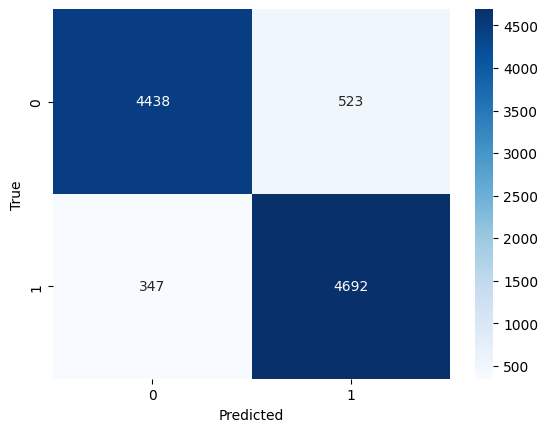

In [34]:
# Confusion matrix
from sklearn.metrics import confusion_matrix


# Assuming you have your true labels and predicted labels
cm= confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Prediction

In [25]:
# Function to make predictions on new text inputs
def predict_sentiment(model, tokenizer, text):
    # Tokenize and encode the input text
    encoded_input = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True,
        return_tensors="tf"
    )

    # Make predictions
    output = model(encoded_input)
    probabilities = tf.nn.softmax(output.logits, axis=1).numpy()[0]
    predicted_label = np.argmax(probabilities)
    confidence_score = probabilities[predicted_label]

    # Decode the predicted label
    label = "positive" if predicted_label == 1 else "negative"

    return label, confidence_score

# Example text input
text_input = "This movie was really great! I loved the storyline and the acting."

# Make prediction
predicted_label, confidence_score = predict_sentiment(model, tokenizer, text_input)
print("Predicted Label:", predicted_label)
print("Confidence Score:", confidence_score)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Predicted Label: positive
Confidence Score: 0.9753504


In [26]:
# Save the model to a directory
model.save_pretrained('my_bert_model')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save_pretrained('/content/drive/My Drive/my_bert_model')

## Sentiment Analysis using DistillBert

In [35]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [36]:
# Tokenize and encode the data
def convert_example_to_feature(review):
    return tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True
    )

In [37]:
def map_example_to_dict(input_ids, attention_masks, label):
    return {
        "input_ids": input_ids,
        "attention_mask": attention_masks
    }, label

In [38]:
def encode_examples(ds, limit=-1):
    input_ids_list = []
    attention_mask_list = []
    label_list = []
    if limit > 0:
        ds = ds.take(limit)
    for review, label in tfds.as_numpy(ds):
        bert_input = convert_example_to_feature(review.decode())
        input_ids_list.append(bert_input['input_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, label_list)).map(map_example_to_dict)

In [39]:
# Prepare TensorFlow datasets
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

ds_train_encoded = encode_examples(ds_train).shuffle(10000).batch(12)
ds_test_encoded = encode_examples(ds_test).batch(12)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [42]:
# Initialize and compile the model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Compile the model
# Choosing Adam optimizer
optimizer = tf.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

# Loss function and metric
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.metrics.SparseCategoricalAccuracy('accuracy')
# Compile the model
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[metric]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [43]:
# Train the model
history=model.fit(ds_train_encoded, epochs=2, validation_data=ds_test_encoded)
history

Epoch 1/2
3334/3334 [==============================] - 2504s 744ms/step - loss: 0.2897 - accuracy: 0.8778 - val_loss: 0.2183 - val_accuracy: 0.9113
Epoch 2/2
3334/3334 [==============================] - 2470s 741ms/step - loss: 0.1620 - accuracy: 0.9407 - val_loss: 0.2328 - val_accuracy: 0.9104


In [44]:
from google.colab import drive
drive.mount('/content/drive')
model.save_pretrained('/content/drive/My Drive/my_distilbert_model')

Mounted at /content/drive


In [47]:
# Save the model to a directory
model.save_pretrained('my_distilbert_model')

In [45]:
from sklearn.metrics import classification_report

# Assuming you have your model predictions and true labels
predictions = model.predict(ds_test_encoded)
predicted_classes = np.argmax(predictions.logits, axis=1)
true_classes = y_test

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=['Negative', 'Positive'])
print(report)

834/834 [==============================] - 202s 240ms/step
              precision    recall  f1-score   support

    Negative       0.89      0.93      0.91      4961
    Positive       0.93      0.89      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



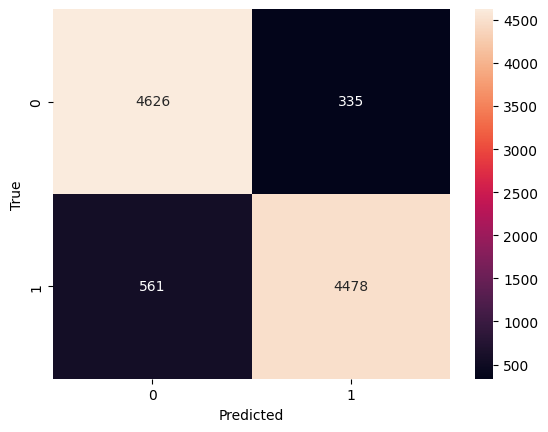

In [46]:
# Confusion matrix
from sklearn.metrics import confusion_matrix


# Assuming you have your true labels and predicted labels
cm= confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Pushing The model to Hugging Fce Hub

In [49]:
!pip install sentencepiece --q

In [50]:
!pip install huggingface_hub --q

In [ ]:
!huggingface-cli login

In [52]:
model.push_to_hub("MariamKili/my_distilbert_model")

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Sentiment Analysis Web Application Implementation using

In [ ]:
!pip install gradio

In [72]:
import gradio as gr
# Function to make predictions on new text inputs
def predict_sentiment(text):
    # Tokenize and encode the input text
    encoded_input = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True,
        return_tensors="tf"
    )

    # Make predictions
    output = model(encoded_input)
    probabilities = tf.nn.softmax(output.logits, axis=1).numpy()[0]
    predicted_label = np.argmax(probabilities)
    confidence_score = probabilities[predicted_label]

    # Decode the predicted label
    label = "positive" if predicted_label == 1 else "negative"

    return label, confidence_score

# Create the Gradio interface
text_input = gr.components.Textbox(lines=5, label="Enter your text here")
output_text = gr.components.Textbox(label="Predicted Sentiment")

# Define the Gradio interface
iface=gr.Interface(fn=predict_sentiment, inputs=text_input, outputs=output_text, title="Sentiment Analysis")

In [73]:
# Launch the Gradio app
iface.launch(
    server_port=7860,  # Set the port number for the server
    server_name="0.0.0.0"  # Set the server name (0.0.0.0 allows access from any device in the network)
)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://8bf2f8ae82e725538c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
